# Neural Style Transfer

## Initialization

In [1]:
# Install required libraries
!pip install -q torch_snippets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 35.3 MB/s eta 0:00

In [2]:
# Import libraries
import numpy as np

import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torchvision.models import vgg19
from torch_snippets import *

from PIL import Image
from matplotlib import pyplot as plt

print(f"PyTorch Version: {torch.__version__}")
!nvidia-smi # check if GPU is available
%matplotlib inline

PyTorch Version: 2.2.1+cu121

Thu Mar 28 03:24:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda

In [4]:
# Create preprocess and postprocess pipelines for the images
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # ImageNet mean and std
    T.Lambda(lambda x: x.mul_(255))
])

postprocess = T.Compose([
    T.Lambda(lambda x: x.mul_(1./255)),
    T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
])

In [5]:
# Create a class to calculate the Gram Matrix
class GramMatrix(nn.Module):
    def forward(self, _input):
        b, c, h, w = _input.size() # batch, channels, height, width
        features = _input.view(b, c, h*w)
        gram_matrix = features @ features.transpose(1, 2)
        return gram_matrix.div_(h*w) # Return the normalized Gram Matrix

# Create a class to calculate the MSE Loss of the Gram Matrix
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        return F.mse_loss(GramMatrix()(input), target)

In [6]:
# Create a modified VGG19 model class to return the output of the specified layers
class vgg19_modified(nn.Module):
    def __init__(self):
        super().__init__()
        features = list(vgg19(weights='IMAGENET1K_V1').features)
        self.features = nn.ModuleList(features).eval()

    def forward(self, x, layers=None):
        if layers is None:
            layers = []
        sorted_layers = np.argsort(layers)
        _results, results = [], []
        # Pass the input through the model's layers and store the output of the specified layers
        for idx, model in enumerate(self.features):
            x = model(x)
            if idx in layers: _results.append(x)
        results.extend(_results[sorted_layer] for sorted_layer in sorted_layers)
        return results if layers is not [] else x

In [7]:
# Load the modified VGG19 model
model = vgg19_modified().to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 75.6MB/s]


In [8]:
# Download the content and style images
root_dir = '/content'
!wget -q https://wildlifesos.org/wp-content/uploads/2023/06/IMG_5193-900x600.jpg -P {root_dir} -O content.jpg
!wget -q https://m.media-amazon.com/images/I/51DvGTpdXKL._AC_UF894,1000_QL80_.jpg -P {root_dir} -O style.jpg

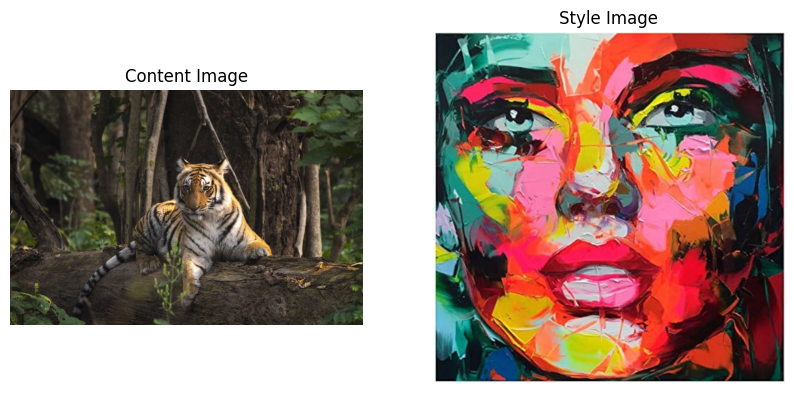

In [9]:
# Plot the content and style images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(Image.open('content.jpg'))
ax[0].axis('off')
ax[0].set_title('Content Image')
ax[1].imshow(Image.open('style.jpg'))
ax[1].axis('off')
ax[1].set_title('Style Image')
plt.show()

In [10]:
# Resize the images to 512x512x3 (3 channels for RGB)
images = [Image.open(f'{root_dir}/{image_stem}').resize((512, 512)).convert('RGB') for image_stem in ['content.jpg', 'style.jpg']]

# Preprocess the images and move them to the device
content_image_tensor, style_image_tensor = [preprocess(image).to(device)[None] for image in images]

In [11]:
# Define the image to optimize (the content image) and set it to require gradients
optimization_image = content_image_tensor.clone().requires_grad_(True)

In [12]:
# Define the layers to be used for the style and content loss
style_layers = [0, 5, 10, 19, 28]
content_layers = [21]
loss_layers = style_layers + content_layers

In [13]:
# Define the loss functions for the style and content loss
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]

In [14]:
# Define the weights for the style and content loss
style_weights = [1000/n**2 for n in [64, 128, 256, 512, 512]]
content_weights = [1]
weights = style_weights + content_weights

In [15]:
# Define the targets for the style and content loss
style_targets = [GramMatrix()(features).detach() for features in model(style_image_tensor, style_layers)]
content_targets = [features.detach() for features in model(content_image_tensor, content_layers)]
targets = style_targets + content_targets

In [16]:
# Define the optimizer and the log
max_iters = 500
optimizer = optim.LBFGS([optimization_image])
log = Report(max_iters)

In [17]:
# Perform the optimization
iters = 0
while iters < max_iters:
    def closure():
        global iters
        iters += 1
        optimizer.zero_grad()
        out = model(optimization_image, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a, A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        log.record(pos=iters, loss=loss, end='\r')
        return loss
    optimizer.step(closure)

EPOCH: 502.000  loss: 572451.938  (64.29s - -0.26s remaining)

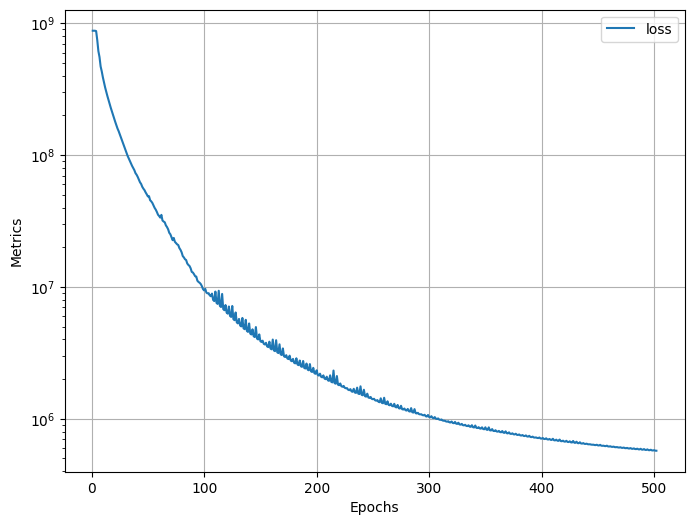

In [18]:
# Plot the loss
log.plot(log=True)

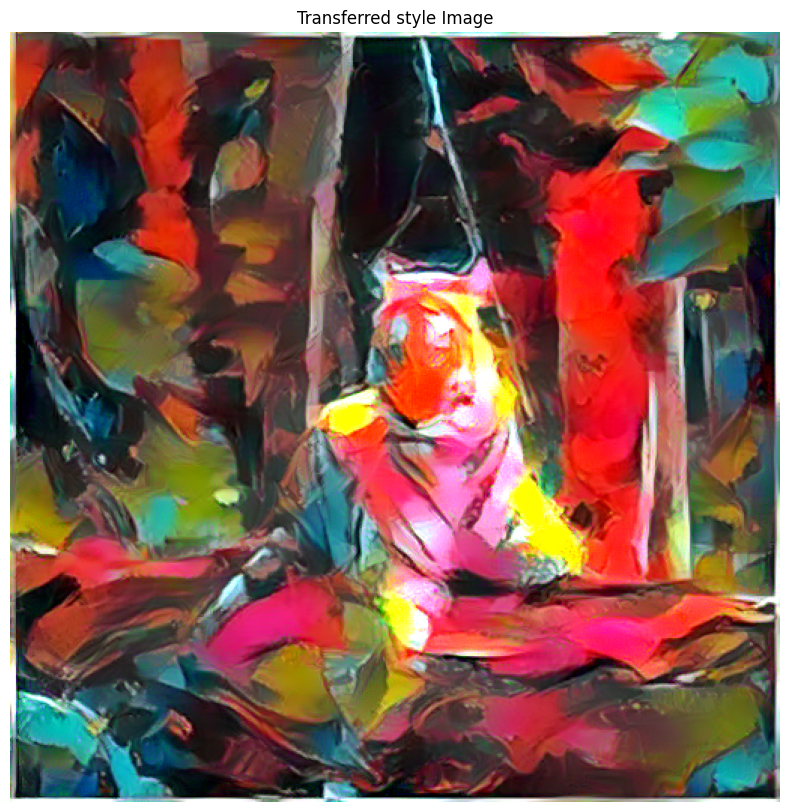

In [19]:
# Plot the resulting image
with torch.no_grad():
    output_image = postprocess(optimization_image[0]).permute(1, 2, 0)
show(output_image, title='Transferred style Image')